In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

### Leitura dos dados

In [2]:
# Para ver o comportamento das variáveis
path = Path('../data/birds.csv') 
df = pd.read_csv(path, sep=';')
df

,normalize,NO_FEATURE_PREPROCESSING,mlfs.igmf_adapted.PyIT_IGMF,mlfs.igmf_adapted.PyIT_IGMF-n_features,mlfs.ppt_mi_adapted.PyIT_PPT_MI,mlfs.ppt_mi_adapted.PyIT_PPT_MI-n_features,mlfs.scls_adapted.PyIT_SCLS,mlfs.scls_adapted.PyIT_SCLS-n_features,mlfs.lrfs_adapted.PyIT_LRFS,mlfs.lrfs_adapted.PyIT_LRFS-n_features,...,weka.classifiers.functions.supportVector.NormalizedPolyKernel,weka.classifiers.functions.supportVector.NormalizedPolyKernel-E,weka.classifiers.functions.supportVector.NormalizedPolyKernel-L,weka.classifiers.functions.supportVector.Puk,weka.classifiers.functions.supportVector.Puk-O,weka.classifiers.functions.supportVector.Puk-S,weka.classifiers.functions.supportVector.RBFKernel,weka.classifiers.functions.supportVector.RBFKernel-G,F1 (macro averaged by label),Model Size
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256,37076.0
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,29686.0
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026,18387.0
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543,6177677.0
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171,28237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135910,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077,1172364.0
135911,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135912,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.169,232446.0
135913,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.290,486521.0


#### Notas
- A primeira coluna se refere a 'normalização', e seus valores podem assumir 0 (caso NÃO tenha normalização aplicada) ou 1 (caso TENHA normalização aplicada). Não sei ao certo o que essa normalização significa.

- A segunda coluna se refere à etapa de 'feature preprocessing'. Caso tenha ocorrido, a célula tem o valor NaN; caso NÃO tenha ocorrido, a célula fica como 0.

- Há muitas colunas NaN. Cada NaN representa um 'não se aplica', por exemplo, caso um algoritmo não tenha sido usado naquela execução, sua célula será NaN e seus hiperparâmetros também.  

- Caso um algoritmo tenha sido usado naquela execução, sua célula será 0.0 (indicando um 'se aplica') e seus hiperparâmetros serão os valores reais que foram usados naquela execução.

Os padrões acima se repetem durante todo o dataset, exceto para as duas últimas colunas (F1-score e Model Size, respectivamente)

- As duas últimas colunas (F1-score e Model Size) assumem os valores reais ou NaN caso não tenham sido calculadas (ou seja, algumas execuções possuem ambos os valores "target" e algumas não possuem nenhum)

- O tamanho do dataset é "129563 rows × 209 columns"

- Existem features (colunas) categóricas, como as dos algoritmos, que indicam apenas sim ou não para determinado algoritmo; também existem features numéricas, como os hiperparâmertros dos algoritmos que foram utilizados em determinada execução ou os "targets"

### Limpeza e Padronização dos dados:
- Remover execuções que os targets sejam NaN;
- Renomear a coluna 'feature preprocessing' para um formato mais intuitivo e padrão;
- Binarizar a coluna 'feature preprocessing';
- Binarizar as colunas categóricas (nome dos algoritmos):
Caso a coluna possua o caractere '-' ela será uma coluna de **hiperparâmetros** e não deve ser incluída na lista; caso contrário, ela será incluída e binarizada. Isso será feito para todas as colunas exceto as 2 primeiras e últimas, que são casos especiais;
- Preencher as colunas numéricas (colunas que representam hiperparâmetros) com -1. Esse valor será usado pois alguns hiperparâmetros podem assumir o valor 0, e usar este valor pode confundir o modelo. Além disso, nenhum hiperparâmetro assume -1;
 
O dataset completo possui 60 colunas categóricas (nome dos algoritmos), 145 colunas numéricas (hiperparâmetros) e 4 "especiais": normalize, feature preprocessing, F1-score e Model Size.

In [3]:
# Execuções sem os valores dos targets não servem para treinar um modelo;
df.dropna(subset=['F1 (macro averaged by label)', 'Model Size'], inplace=True)

# Modelos lidam melhor com valores binários ao invés de NaN
df = df.rename(columns={'NO_FEATURE_PREPROCESSING': 'feature preprocessing'})
df['feature preprocessing'] = df['feature preprocessing'].apply(lambda x: 0 if x == 0 else 1)

In [4]:
# Lista de colunas que serão binarizadas (categóricas)
# As 2 primeiras e últimas são especiais
columns = [column for column in df.columns[2:-2] if '-' not in column]

for column in columns:
    df[column] = df[column].apply(lambda x: 1 if x == 0 else 0)

In [5]:
# Lista de colunas numéricas
columns_to_fill = [
    col for col in df.columns[2:-2]
    if col not in columns
]

# Preenchendo com -1 pois hiperparâmetros podem assumir valor 0 
df[columns_to_fill] = df[columns_to_fill].fillna(-1)

### Verificação final e gráficos

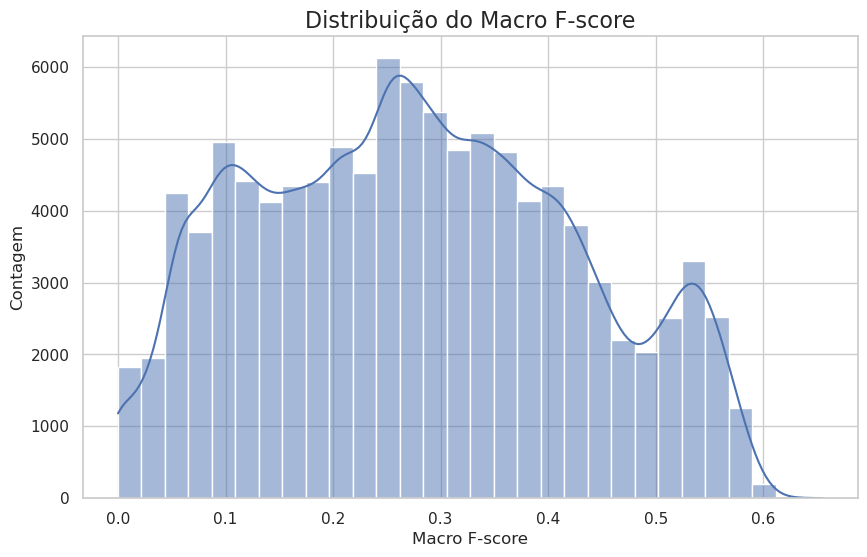

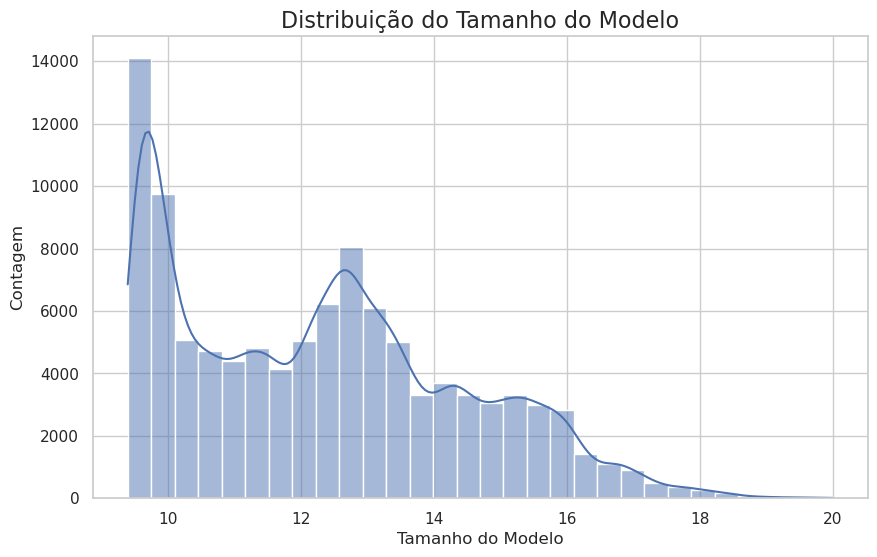

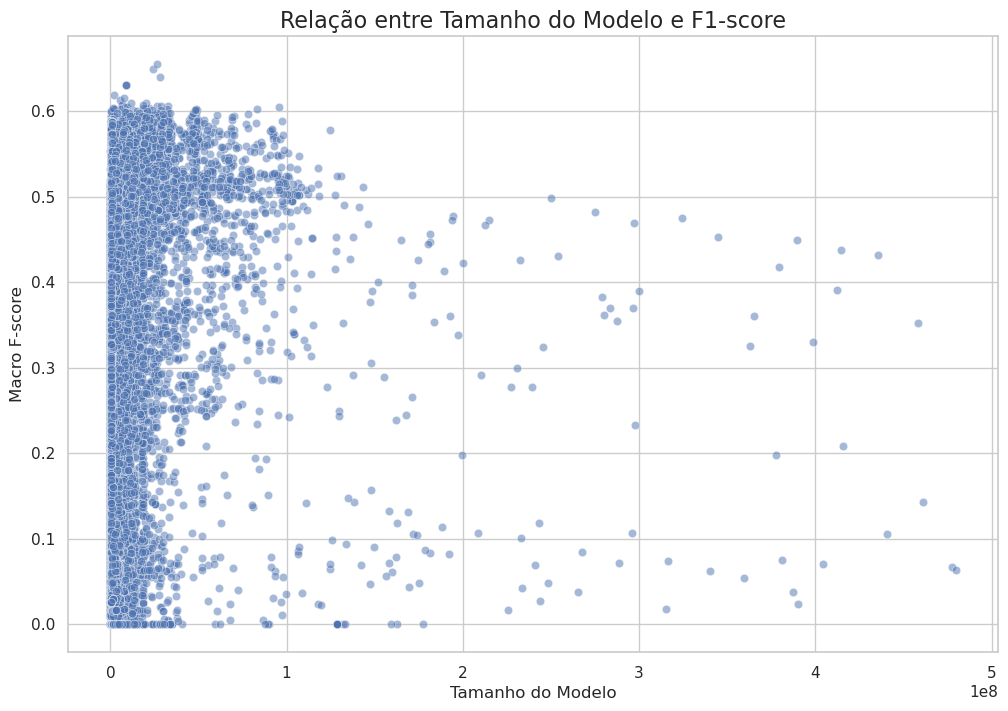

In [6]:
# Para desfragmentar a memória (otimizar)
clean_df = df.copy()

# Plotando gráficos para identificar padrões
clean_df['Model Size Log'] = np.log1p(clean_df['Model Size'])

sns.set_theme(style="whitegrid")

# Histograma do Macro F-score 
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['F1 (macro averaged by label)'], kde=True, bins=30)
plt.title('Distribuição do Macro F-score', fontsize=16)
plt.xlabel('Macro F-score')
plt.ylabel('Contagem')
plt.show()

# Histograma do Tamanho do Modelo 
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['Model Size Log'], kde=True, bins=30)
plt.title('Distribuição do Tamanho do Modelo', fontsize=16)
plt.xlabel('Tamanho do Modelo')
plt.ylabel('Contagem')
plt.show()

# Scatter Plot (Relação entre os Alvos)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=clean_df, x='Model Size', y='F1 (macro averaged by label)', alpha=0.5)
plt.title('Relação entre Tamanho do Modelo e F1-score', fontsize=16)
plt.xlabel('Tamanho do Modelo')
plt.ylabel('Macro F-score')
plt.show()

#### Ao que os gráficos indicam, o F1-score tende a concentrar-se em 0.3; o tamanho dos modelos tende a ser menor; não há relação entre tamanho do modelo e F1-score

In [7]:
# Salvando o df limpo em .csv novamente
clean_df.to_csv('../proc_data/proc_birds.csv', index=False)

# Última verificação
nans = df.isnull().sum().sum()
print(f"total de NaNs após o processamento: {nans}")
df.head(5)

total de NaNs após o processamento: 0


,normalize,feature preprocessing,mlfs.igmf_adapted.PyIT_IGMF,mlfs.igmf_adapted.PyIT_IGMF-n_features,mlfs.ppt_mi_adapted.PyIT_PPT_MI,mlfs.ppt_mi_adapted.PyIT_PPT_MI-n_features,mlfs.scls_adapted.PyIT_SCLS,mlfs.scls_adapted.PyIT_SCLS-n_features,mlfs.lrfs_adapted.PyIT_LRFS,mlfs.lrfs_adapted.PyIT_LRFS-n_features,...,weka.classifiers.functions.supportVector.NormalizedPolyKernel,weka.classifiers.functions.supportVector.NormalizedPolyKernel-E,weka.classifiers.functions.supportVector.NormalizedPolyKernel-L,weka.classifiers.functions.supportVector.Puk,weka.classifiers.functions.supportVector.Puk-O,weka.classifiers.functions.supportVector.Puk-S,weka.classifiers.functions.supportVector.RBFKernel,weka.classifiers.functions.supportVector.RBFKernel-G,F1 (macro averaged by label),Model Size
0,0,1,0,-1.0,0,-1.0,0,-1.0,0,-1.0,...,0,-1.0,-1.0,0,-1.0,-1.0,0,-1.0,0.256,37076.0
1,0,1,0,-1.0,0,-1.0,0,-1.0,0,-1.0,...,0,-1.0,-1.0,0,-1.0,-1.0,0,-1.0,0.222,29686.0
2,0,1,0,-1.0,0,-1.0,0,-1.0,0,-1.0,...,0,-1.0,-1.0,0,-1.0,-1.0,0,-1.0,0.026,18387.0
3,0,1,0,-1.0,0,-1.0,0,-1.0,0,-1.0,...,0,-1.0,-1.0,0,-1.0,-1.0,0,-1.0,0.543,6177677.0
4,0,1,0,-1.0,0,-1.0,0,-1.0,0,-1.0,...,0,-1.0,-1.0,0,-1.0,-1.0,0,-1.0,0.171,28237.0
